<a href="https://colab.research.google.com/github/helenatong/oc_p3_cleaning_dataset_and_analysis/blob/main/project3_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prerequisites**
- Download [this zip file](https://drive.google.com/file/d/1xOFMkJsbYqlR5MnkCxrgCyUOnl9zoIya/view?usp=drive_link) in Google Drive
- Modify files' path (zip_path et extract_path) within the code, 1 file in the zip


 ---

## **Context and description**

Public Health Agency France provides in opensource the database "fr.openfoodfacts.org.products", which contains information about food products sold in various points of sale.

This initiative aims to inform the public about the nutritional quality of foods. Data on each product is organized around five main themes: general product information (barcode, name), tags (packaging, category, origin, label), ingredients, nutritional information per 100g (energy, protein, sugar, sucrose, lactose), and additional information.

The objective of the study is to determine whether it is feasible to predict the values of a given variable in the dataset. The method I followed involves selecting the target variable to predict, then choosing a few relevant variables for its prediction. To determine if it is feasible, I will predict the target variable, then see the score and conclude if it's a great method. Finally, this will be followed by an exploratory analysis.

I chose to study a categorical target variable, which is the group to which the products belong.

 ---

## **Summary**

### **I. Installing and setting up the work environment**
### **II. Definitions of auxiliary functions**
### **III. Exploratory phase**
### **IV. Delete impossible values deletion**
### **V. Data pre-processing by imputation : Replace NaN values**
### **VI. Predict and Access the quality of prediction**
### **VII. Data analysis**



# **I. Installing and setting up the work environment**

---



In [2]:
# importation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import missingno as msno

import zipfile
import os
import sys
import datetime

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [3]:
# informations on virtual environment
print('Version of libraries :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Missingno     : ' + msno.__version__)
print('seaborn       : ' + sns.__version__)
print('matplotlib    : ' + mpl.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version of libraries :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Missingno     : 0.5.2
seaborn       : 0.13.1
matplotlib    : 3.7.1
Run date      : 2024-04-11T21:51:41.153581


In [4]:
# configuration on data's display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [5]:
# connection to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# unzip file

## ⚙️ if needed, modify the path
zip_path = '/content/drive/MyDrive/openclassrooms/project_list/project_3/fr.openfoodfacts.org.products.csv.zip'
extract_path = '/content/drive/MyDrive/openclassrooms/project_list/project_3/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

path_country = os.path.join(extract_path, 'fr.openfoodfacts.org.products.csv')

In [7]:
# create dataframe for our imported file
df = pd.read_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/fr.openfoodfacts.org.products.csv', sep = '\t', low_memory = False)

In [8]:
# check data importation
print(df.head(2))

            code                                                url  \
0  0000000003087  http://world-fr.openfoodfacts.org/produit/0000...   
1  0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1             usda-ndb-import  1489069957  2017-03-09T14:32:37Z   

  last_modified_t last_modified_datetime                    product_name  \
0      1474103893   2016-09-17T09:18:13Z              Farine de blé noir   
1      1489069957   2017-03-09T14:32:37Z  Banana Chips Sweetened (Whole)   

  generic_name quantity  ... ph_100g fruits-vegetables-nuts_100g  \
0          NaN      1kg  ...     NaN                         NaN   
1          NaN      NaN  ...     NaN                         NaN   

  collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
0                              NaN        NaN             NaN   
1                   

**CONFIGURATION**

In [9]:
TARGET = 'pnns_groups_1'
PRODUCT_NAME = 'product_name'
NUMERIC_FEATURES =  ['energy_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g']
ALL_VARIABLES = NUMERIC_FEATURES + [PRODUCT_NAME] + [TARGET]

# **II. Definitions of auxiliary functions**


In [10]:
def correlation_graph(pca, x_y, features) :
    """
    Displays the correlation graph
    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : our PCA object which has been fit
    x_y : list or tuple : the x,y pair of planes to be displayed, e.g. [0,1] for F1, F2
    features : list or tuple : the list of features (i.e. dimensions) to represent
    """
    x,y=x_y
    fig, ax = plt.subplots(figsize=(10, 9))

    for i in range(0, pca.components_.shape[1]):

        # arrow
        ax.arrow(0,0, pca.components_[x, i], pca.components_[y, i], head_width=0.07, head_length=0.07, width=0.02)
        # labels
        plt.text(pca.components_[x, i] + 0.05, pca.components_[y, i] + 0.05, NUMERIC_FEATURES[i])

    # vertical and horizontal rows
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # axis name and percentage of inertia explained
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    plt.title("Correlation circle (F{} et F{})".format(x+1, y+1))

    # circle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [11]:
def display_factorial_planes(X_projected, x_y, pca=None, labels = None, clusters=None, alpha=1, figsize=[10,8], marker="." ):
    """
    Displays the projection of individuals
    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : the matrix of projected points
    x_y : list or tuple : the x,y pair of planes to be displayed, e.g. [0,1] for F1, F2
    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : a PCA object that has been fit, this will allow us to display the variance of each component, default = None
    labels : list or tuple : the labels of the individuals to be projected, default = None
    clusters : list or tuple : the list of clusters to which each individual belongs, default = None
    alpha : float in [0,1] : transparency parameter, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list or tuple : width, height pair defining the size of the figure in inches, default = [10,8].
    marker : str : type of marker used to represent individuals, crosshairs etc etc, default = "."".
    """

    X_ = np.array(X_projected)
    if not figsize:
        figsize = (7,6)

    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    x, y = x_y
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    c = None if clusters is None else clusters
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # x and y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # horizontal and vertical rows
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # labels
    if len(labels) :
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='12', ha='center',va='center')

    plt.title(f"Projection of individuals (on F{x+1} and F{y+1})")
    plt.show()

# **III. Exploratory phase**
---
  
- choose the target variable (1)
- select all relevant variables for target variable analysis (9)
- remove duplicates and unnecessary informations

## A. Cleaning and choice of the target variable

To choose the target variable, I first cleaned up by deleting empty columns and rows to simplify the database.
I then chose a categorical variable with a missing value greater than 50% (customer requirement). This first step is a technical constraint, then I'll use the business constraint to choose the most relevant variable to analyze.

**Cleaning**

In [ ]:
# dataframe dimension
nb_row, nb_column = df.shape

print(f'number of rows : {nb_row} \nnumber of columns : {nb_column}')

In [ ]:
# remove empty column
is_empty_column = df.isna().sum(axis = 0) == nb_row
empty_column = df.columns[is_empty_column]
print(f'{is_empty_column.sum()} columns dropped. \nList of dropped columns :\n {empty_column}')
df.drop(empty_column, axis = 1, inplace = True)

In [ ]:
# remove empty rows
is_empty_row = df.isna().sum(axis = 1) == nb_column
empty_row = df.index[is_empty_row]
print(f'There is {is_empty_row.sum(axis = 0)} empty rows')

In [ ]:
# missing value
nb_row, nb_column = df.shape
missing_counts = df.isna().sum()
missing_percentage = (missing_counts / nb_row) * 100

missing_summary = pd.DataFrame({
    'mv(nb)': missing_counts,
    'mv(%)': missing_percentage.apply(lambda x: f'{x:.2f}%')
})

pd.set_option('display.max_rows', None)
print(f'Missing value :')
print(missing_summary.sort_values('mv(nb)'))
pd.reset_option('display.max_rows')

**Choose the target variable**

From a technical point of view, according to this list, the categorical variables that have between 50% and 80% missing values are the following: additives_tags, additives_fr, pnns_groups_2, pnns_groups_1, categories_fr, categories, categories_tags, main_category_fr, main_category, packaging_tags, packaging.

From a business point of view, it's interesting to be able to predict values of the group of food a product belongs to.

Let's now look at the content of the following variables.

In [ ]:
main_variable_selection = ['pnns_groups_2', 'pnns_groups_1', 'categories', 'categories_tags', 'main_category']

for var in main_variable_selection:
    print('examples of values in', var , ':\n', df[var].unique()[:5], end = '\n---\n')

In [ ]:
# display all element in each pnns_groups variable
print('all values in pnns_groups_1 :\n', df['pnns_groups_1'].unique(), end = '\n---\n')
print('all values in pnns_groups_2 :\n', df['pnns_groups_2'].unique())

Category variable are not homogenous in one language, I'm choosing pnns_groups_1 which is more concise as pnns_groups_2.

In [ ]:
# harmonize value for the target variable
mapping = {
    'fruits-and-vegetables' : 'Fruits and vegetables',
    'sugary-snacks'   : 'Sugary snacks',
    'salty-snacks'   : 'Salty snacks',
    'cereals-and-potatoes' : 'Cereals and potatoes',
    ''   : '',
}

df[TARGET] = df[TARGET].replace(mapping)

print('updated values in {TARGET} :\n', df[TARGET].unique())

## B. Choose revelant variable to analyze the target variable

To choose feature variable for the target variable, I prioritize variable with > 50% of available value.

In [ ]:
# checing the % of available value
nb_row, nb_column = df.shape
missing_counts = df.isna().sum()
missing_percentage = (missing_counts / nb_row) * 100

missing_summary = pd.DataFrame({
    'mv(nb)': missing_counts,
    'mv(%)': missing_percentage.apply(lambda x: f'{x:.2f}%')
})

pd.set_option('display.max_rows', None)
print(f'Missing value :')
print(missing_summary.sort_values('mv(nb)'))
pd.reset_option('display.max_rows')

Among the variables the following one are the one chosen for the analyze :
- product_name : to identify the product
- energy_100g : related to the product's nutritional value
- proteins_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, sodium_100g*, fiber_100g related to the the product composition.

*I chose sodium_100g over salt_100g which is an arbitrary choice. (1g of sodium = 2,5g of salt)*


In [ ]:
# drop unused variables

col_to_drop = df.columns.difference(ALL_VARIABLES)
df.drop(columns = col_to_drop, inplace = True)

In [ ]:
df

## C. Cleaning the dataset with selected variables

Remove empty rows, duplicates and non informative rows

In [ ]:
# remove rows without product name
removed_rows = df[PRODUCT_NAME].isna().sum()
print(f'{removed_rows} rows without product name have been removed')

df.dropna(subset=[PRODUCT_NAME], inplace=True)

In [ ]:
# remove empty rows, an empty row is NaN value for quantitative variables (does not include product_name and pnns_groups_2)
is_empty_row = df[NUMERIC_FEATURES].isna().sum(axis = 1) >= len(NUMERIC_FEATURES) - 1
empty_row = df.index[is_empty_row]
print(f'{is_empty_row.sum(axis = 0)} empty rows have been removed')

df.drop(empty_row, axis = 0, inplace = True)

In [ ]:
# remove duplicates, a duplicate is 2 rows with the same product_name
nb_duplicate = df.duplicated(subset = PRODUCT_NAME).sum()
print(f'{nb_duplicate} duplicated rows have been removed')

df.drop_duplicates(subset = PRODUCT_NAME, inplace = True)
print(f'remaining rows : {df.shape[0]}')

In [ ]:
# matrix to see missing values
f, axes = plt.subplots(1,2, figsize=(30, 10))

msno.bar(df,
         color="dodgerblue",
         sort="descending",
         ax = axes[0]
        ).set_title("Graph of missing values \n", fontsize = 30)

msno.matrix(df,
            color=(0.27, 0.52, 1.0),
            sort="descending",
            sparkline = False,
            ax = axes[1]
           ).set_title("Matrix of missing values \n", fontsize = 30)

# **IV. Delete impossible values deletion**
---

The quantity for the nutrient variable (proteins_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, sodium_100g, fiber_100g) can not exceed 100g.

At maximum, a product can contains 900 kcal or 3766 kJ which is a product with fat_100g = 100g. Indeed 1g of protein contains 4 calories, 1g of carbohydrates contains 4 calories, 1g of fat contains 9 calories, 1g of fiber contains 2 calories.

Therefore, I removed those impossible values.

In [ ]:
# remove impossible value
mask = ((df['proteins_100g'] > 100) | (df['fat_100g'] > 100) | (df['saturated-fat_100g'] > 100) | (df['carbohydrates_100g'] > 100) | (df['sugars_100g'] > 100) | (df['sodium_100g'] > 100) | (df['fiber_100g'] > 100) | (df['energy_100g'] > 3766))
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

The sum of the quantity for the nutrient variables proteins_100g, fat_100g, carbohydrates_100g, sodium_100g, fiber_100g can not exceed 100g

In [ ]:
# remove impossible value
mask = (df['proteins_100g'] + df['fat_100g'] + df['carbohydrates_100g'] + df['sodium_100g'] + df['fiber_100g'] > 100)
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

Quantitative variables can not be negative

In [ ]:
# remove impossible value
mask = ((df['proteins_100g'] < 0) | (df['fat_100g'] < 0) | (df['saturated-fat_100g'] < 0) | (df['carbohydrates_100g'] < 0) | (df['sugars_100g'] < 0) | (df['sodium_100g'] < 0) | (df['fiber_100g'] < 0) | (df['energy_100g'] < 0))
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

According to business rule : fat_100g > saturated-fat_100g and carbohydrates_100g > sugars_100g

In [ ]:
# remove impossible value
mask = ((df['fat_100g'] < df['saturated-fat_100g']) | (df['carbohydrates_100g'] < df['sugars_100g']))
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

# **V. Data pre-processing by imputation : Replace NaN values**

To address missing values, the following approach will be adopted:

- Initial understanding of variable characteristics: For instance, a missing value for fiber suggests that the product lacks this component
- Exploring potential correlations between variables: Linear regression imputation may be employed if correlations exist between certain variables
- Priority order for imputation: Starting with the most reliable estimates, such as those derived from correlated variables (e.g., fiber = 0), before resorting to less precise methods like statistical imputation

## **A. Impute values**


In [ ]:
df_before_imputation = df.copy()

In [ ]:
# missing value
nb_row, nb_column = df.shape
missing_counts = df.isna().sum()
missing_percentage = (missing_counts / nb_row) * 100

missing_summary = pd.DataFrame({
    'mv(nb)': missing_counts,
    'mv(%)': missing_percentage.apply(lambda x: f'{x:.2f}%')
})

print(f'Missing value :')
print(missing_summary.sort_values('mv(nb)'))

When the value of fiber_100g is missing, the product contains none

In [ ]:
df['fiber_100g'] = df['fiber_100g'].fillna(0)

Let's see correlation matrix to identify methods which can be use to impute values


In [ ]:
# correlation
correlation_matrix = df[NUMERIC_FEATURES].corr()

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix for quantitative variables')
plt.show()

The couple fat/saturated fat and sugars/carbohydrates have a correlation of 0.75 and 0.69 respectively.

Let's plot a graph to check the linearity of the values.


In [ ]:
# extract a sample to have a proper view
df_sample = df.sample(3000)

fat = df_sample['fat_100g']
sfat = df_sample['saturated-fat_100g']
carbohydrate = df_sample['carbohydrates_100g']
sugar = df_sample['sugars_100g']
energy = df_sample['sugars_100g']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# first graph
ax1.scatter(fat, sfat, alpha=0.5, color='blue')
ax1.set_title('scatter plot fat/saturated-fat')
ax1.set_xlabel('fat')
ax1.set_ylabel('saturated-fat')
ax1.grid(True)

# second graph
ax2.scatter(carbohydrate, sugar, alpha=0.5, color='red')
ax2.set_title('scatter plot carbohydrate/sugar')
ax2.set_xlabel('carbohydrates')
ax2.set_ylabel('sugars')
ax2.grid(True)

# second graph
ax3.scatter(fat, energy, alpha=0.5, color='green')
ax3.set_title('scatter plot fat/energy')
ax3.set_xlabel('fat')
ax3.set_ylabel('energy')
ax3.grid(True)

plt.tight_layout()
plt.show()

The linearity is not obvious, I will use KKNImputer method to imput values for sodium, proteins, fat, saturated-fat, sugars, carbohydrates.

In [ ]:
impute_knn = KNNImputer(n_neighbors=3)
columns_to_impute = ['sodium_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'carbohydrates_100g']
df[columns_to_impute] = impute_knn.fit_transform(df[columns_to_impute]) #12min

Since 1g of protein contains 4 calories, 1g of carbohydrates contains 4 calories, 1g of fat contains 9 calories, 1g of fiber contains 2 calories, I can deduct the energy value

In [ ]:
df.loc[df['energy_100g'].isna(), 'energy_100g'] = 4 * df['proteins_100g'] + 4 * df['carbohydrates_100g'] + 9 * df['fat_100g'] + 2 * df['fiber_100g']

## **B. Compare distribution before and after imputation**

In [ ]:
# distribution before imputation
df_before_imputation[NUMERIC_FEATURES].hist(bins=50)
plt.tight_layout()

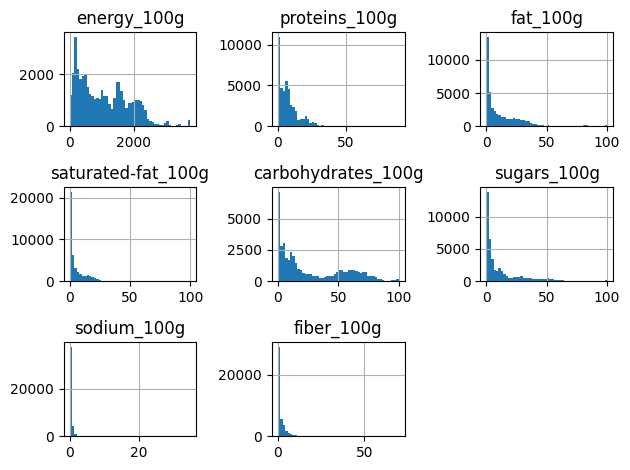

In [ ]:
# distribution after imputation
df[NUMERIC_FEATURES].hist(bins=50)
plt.tight_layout()

Globally, distribution has been preserved.


Small differences are visible for the energy variable, where a peak can be observed around 2000 kJ, and for the sodium variable, where a second peak appears.

# **VI. Predict and Access the quality of prediction**


In [ ]:
# export cleaned data
df.to_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/df_cleaned.csv', index=False)

In [ ]:
# create dataframe for our imported file
df = pd.read_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/df_cleaned.csv', sep = ',', low_memory = False)

Delete NaN value for target variable to train and test models

In [ ]:
# remove NaN value for TARGET
rows_before = df.shape[0]
df.dropna(subset = TARGET, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

Number of rows removed: 0
43468 remaining


In [ ]:
# remove unknown value for TARGET
nb_rows_to_remove = df.loc[df[TARGET] == 'unknown', TARGET].count()
df = df[df[TARGET] != 'unknown']
rows_now = df.loc[df[TARGET] != 'unknown', TARGET].count()

rows_removed = rows_before - rows_now
print(f'Number of rows removed: {nb_rows_to_remove}\n{rows_now} remaining')

Number of rows removed: 0
43468 remaining


In [ ]:
print(df.shape)
df

(43468, 10)


,product_name,pnns_groups_1,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g
0,Salade Cesar,Fruits and vegetables,1210.0,12.000000,7.000000,23.000000,0.000000,2.000,22.000,0.850000
1,Danoises à la cannelle roulées,Sugary snacks,1520.0,14.400000,12.836667,54.100000,28.100000,2.050,4.790,0.363000
2,Chaussons tressés aux pommes,Sugary snacks,1090.0,10.700000,2.000000,38.700000,24.700000,2.000,3.330,0.255000
3,Quiche Lorraine,Composite foods,478.0,6.790000,2.860000,7.860000,0.714000,0.357,5.360,0.196000
4,Pâté au poulet,Fish Meat Eggs,751.0,10.200000,0.366667,16.600000,19.476667,0.000,33.900,0.289000
...,...,...,...,...,...,...,...,...,...,...
43463,Santa Cruz Chilli & Lime Dressing,Fat and sauces,660.0,6.900000,0.500000,23.100000,16.700000,0.600,0.300,0.213000
43464,Fisherman's Friend Miel-Citron,Sugary snacks,1031.0,1.300000,1.280000,95.310000,0.100000,1.470,0.004,0.000394
43465,Nature cheddar and red onion crisps,Salty snacks,2155.0,22.866667,3.400000,34.766667,1.800000,5.600,7.800,0.531496
43466,Tartines craquantes bio au sarrasin,Cereals and potatoes,1643.0,2.800000,0.600000,74.800000,2.600000,5.900,13.000,0.267717


In [ ]:
df[TARGET].value_counts(normalize=True)

pnns_groups_1
Sugary snacks              0.199296
Milk and dairy products    0.142289
Cereals and potatoes       0.131591
Composite foods            0.119306
Beverages                  0.110012
Fish Meat Eggs             0.108310
Fruits and vegetables      0.080703
Fat and sauces             0.065704
Salty snacks               0.042790
Name: proportion, dtype: float64

In [ ]:
# transform the class form text to integer
encoder =  LabelEncoder()
y_encoded = encoder.fit_transform(df[TARGET].values)

# create dataset for training and testing
X = df[NUMERIC_FEATURES].values
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

The target variable is multi-class and categorical. I therefore chose a Gradient Boosting algorithm.

HistGradientBoostingClassifier is faster to train than GradientBoostingClassifier for samples greater than 10000.

In [ ]:
#create pipeline to normalize values and fit model
my_pipeline = Pipeline([
    ('power_transform', PowerTransformer()),
    ('classifier', HistGradientBoostingClassifier())
])

In [ ]:
# check standardization by power_transform
my_pipeline.fit(X_train, y_train_encoded)
X_train_transformed = my_pipeline.named_steps['power_transform'].transform(X_train)
df_transformed = pd.DataFrame(X_train_transformed, columns=NUMERIC_FEATURES)
print(df_transformed.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
print('----------------')

# fit model by using grid search
param_grid = {
    'classifier__max_iter'          : [1000],
    'classifier__max_depth'         : [8, 9, 10],
    'classifier__learning_rate'     : [0.06, 0.07, 0.08],
    'classifier__random_state'      : [42]
}
grid_search = GridSearchCV(my_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1, refit=True)
grid_search.fit(X_train, y_train_encoded)
print(grid_search.best_params_)
print('----------------')

# model scoring
best_model = grid_search.best_estimator_
print(f'Model\'s score : {best_model.score(X_train, y_train_encoded).round(3)}')
print(f'Model\'s score on test dataset : {best_model.score(X_test, y_test_encoded).round(3)}')

      energy_100g proteins_100g  fat_100g saturated-fat_100g  \
count    34774.00      34774.00  34774.00           34774.00   
mean        -0.00          0.00     -0.00              -0.00   
std          1.00          1.00      1.00               1.00   
min         -2.48         -1.69     -1.48              -1.32   
25%         -0.82         -0.83     -0.91              -0.97   
50%          0.10          0.14      0.04              -0.00   
75%          0.81          0.70      0.90               0.92   
max          2.33          3.64      2.13               2.23   

      carbohydrates_100g sugars_100g sodium_100g fiber_100g  
count           34774.00    34774.00    34774.00   34774.00  
mean               -0.00        0.00        0.00      -0.00  
std                 1.00        1.00        1.00       1.00  
min                -1.70       -1.60       -1.22      -0.88  
25%                -0.81       -0.90       -0.98      -0.88  
50%                -0.06       -0.06       -0.02   

The best model obtained is overfitted on training dataset.

In [ ]:
# check prediction's details
y_pred_encoded = best_model.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
y_test = encoder.inverse_transform(y_test_encoded)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

              Beverages       0.94      0.90      0.92       949
   Cereals and potatoes       0.88      0.83      0.85      1140
        Composite foods       0.81      0.83      0.82      1062
         Fat and sauces       0.90      0.84      0.87       579
         Fish Meat Eggs       0.90      0.92      0.91       954
  Fruits and vegetables       0.77      0.79      0.78       651
Milk and dairy products       0.90      0.94      0.92      1212
           Salty snacks       0.83      0.78      0.81       394
          Sugary snacks       0.92      0.94      0.93      1753

               accuracy                           0.88      8694
              macro avg       0.87      0.86      0.87      8694
           weighted avg       0.88      0.88      0.88      8694



Out of 8694 products, 7650 categories were accurately predicted.

The model correctly predicted 90% of the following categories: Beverages, Fish Meat Eggs, Milk and diary products and Sugary snacks.

It performed less well in predicting the Fruit and vegetables category (22% incorrect prediction).

<Axes: >

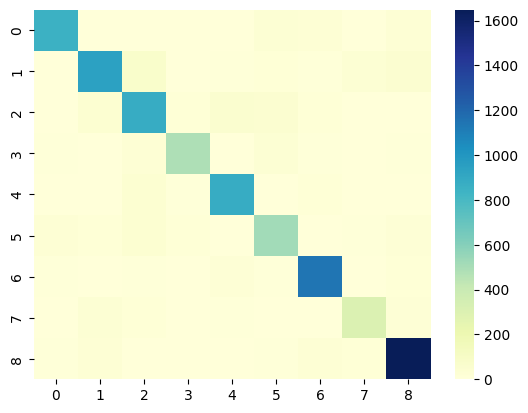

In [ ]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred = y_pred) , cmap="YlGnBu")

Let's see if we can improve our model by increasing the amount of data provided using the learning curve method.

In [ ]:
N, train_score, val_score = learning_curve(best_model, X_train, y_train_encoded,
                                           train_sizes = np.linspace(0.1, 1.0, 5), cv=5)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_size')
plt.legend()

A plateau seems to be reached, so more data won't produce better forecasts.

**Conclusion on the on the feasibility of predicting the target variable**

The main objective is to determine if it is feasible to find a prediction method to fill in the missing data of the target variable pnns_groups_1.

The training dataset achieves a score of 96%, while the test dataset achieves a score of 88%, indicating overfitting.

However, this result is encouraging and represents a good score. Furthermore, it is possible to improve it through various means such as variable selection, imputation method, and model parameter tuning.

# **VII. Data analysis**

## **A. Univariate an Bivariate analysis**

**UNIVARIATE ANALYSIS**

In [13]:
# statistic information
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g
count,43468,43468,43468,43468,43468,43468,43468,43468
mean,1079,13,5,28,13,2,7,0
std,780,16,8,27,18,3,7,1
min,0,0,0,0,0,0,0,0
25%,382,1,0,4,1,0,2,0
50%,975,6,2,15,5,0,6,0
75%,1640,21,8,52,18,2,10,0
max,3766,100,100,100,100,70,88,35


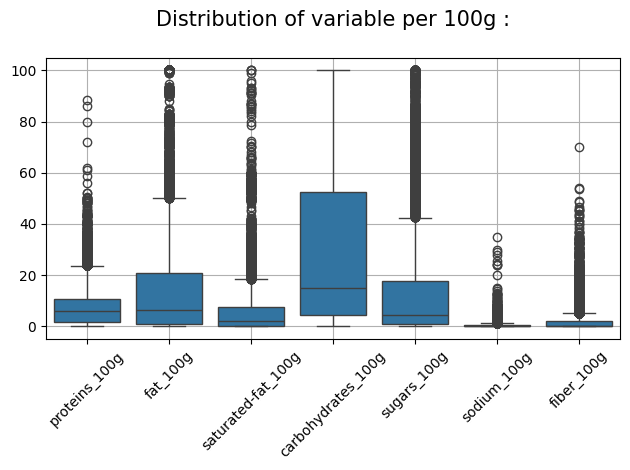

In [14]:
# plot all boxbot to have a general view
comp_feature_variable = ['proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g']
df_melted = pd.melt(df, id_vars = [PRODUCT_NAME, TARGET], value_vars = comp_feature_variable , var_name='variable', value_name='value')

ax = sns.boxplot(x = 'variable', y = 'value', data = df_melted.loc[df_melted['variable'].isin(comp_feature_variable), :])
ax.set_title('Distribution of variable per 100g :\n', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('', fontsize=10)
ax.tick_params(axis='x', labelsize=10, rotation = 45)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)

plt.tight_layout()
plt.show()

<ipython-input-15-869188c7cdc1>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(category_counts.index, rotation=45, ha='right')


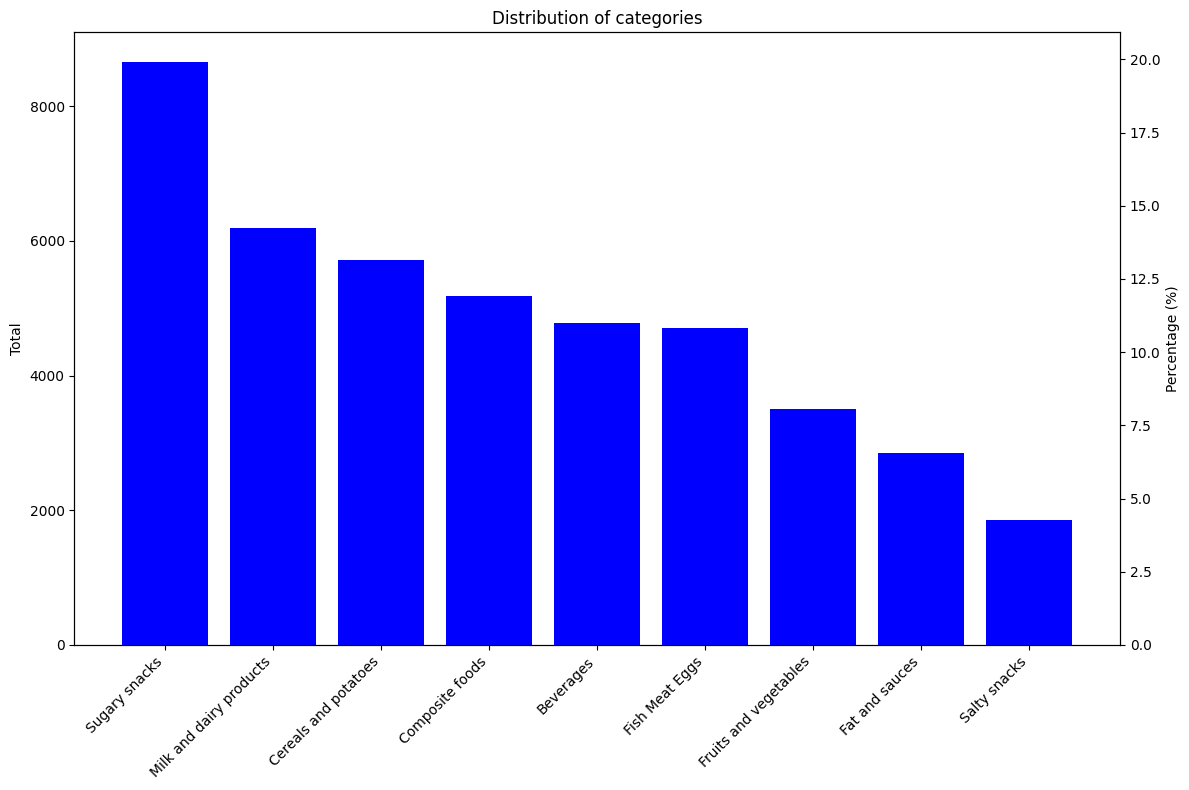

pnns_groups_1
Sugary snacks              19.929603
Milk and dairy products    14.228858
Cereals and potatoes       13.159106
Composite foods            11.930616
Beverages                  11.001196
Fish Meat Eggs             10.830956
Fruits and vegetables       8.070305
Fat and sauces              6.570351
Salty snacks                4.279010
Name: count, dtype: float64


In [15]:
# category distribution
category_counts = df[TARGET].value_counts()

category_percentages = (category_counts / len(df)) * 100
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.bar(category_counts.index, category_counts.values, color='b')

ax2 = ax1.twinx()
ax2.bar(category_counts.index,category_percentages.values, color='b')

ax2.set_ylabel('Percentage (%)')
ax1.set_ylabel('Total')
ax1.set_xticklabels(category_counts.index, rotation=45, ha='right')

plt.title('Distribution of categories')
plt.tight_layout()
plt.show()

print(category_percentages)

**BIVARIATE ANALYSIS**

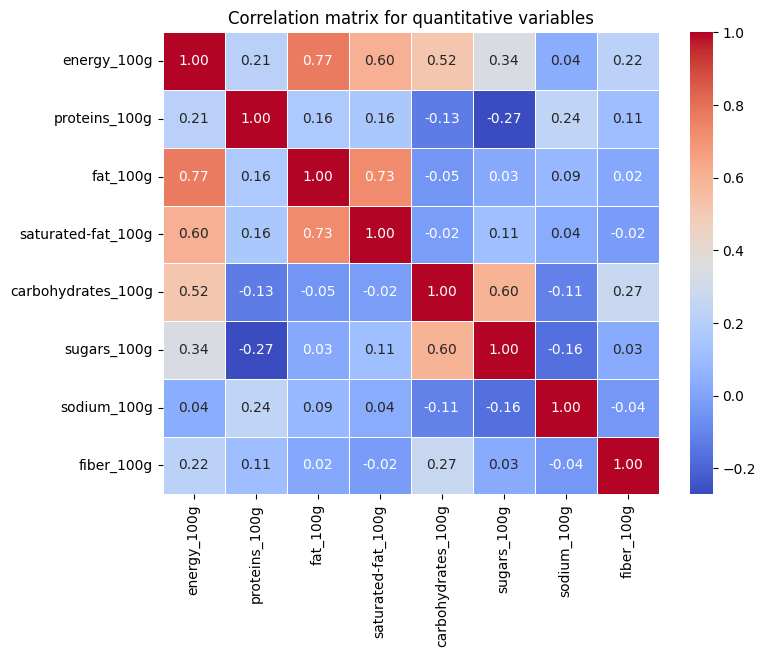

In [16]:
# correlation
correlation_matrix = df[NUMERIC_FEATURES].corr()

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix for quantitative variables')
plt.show()

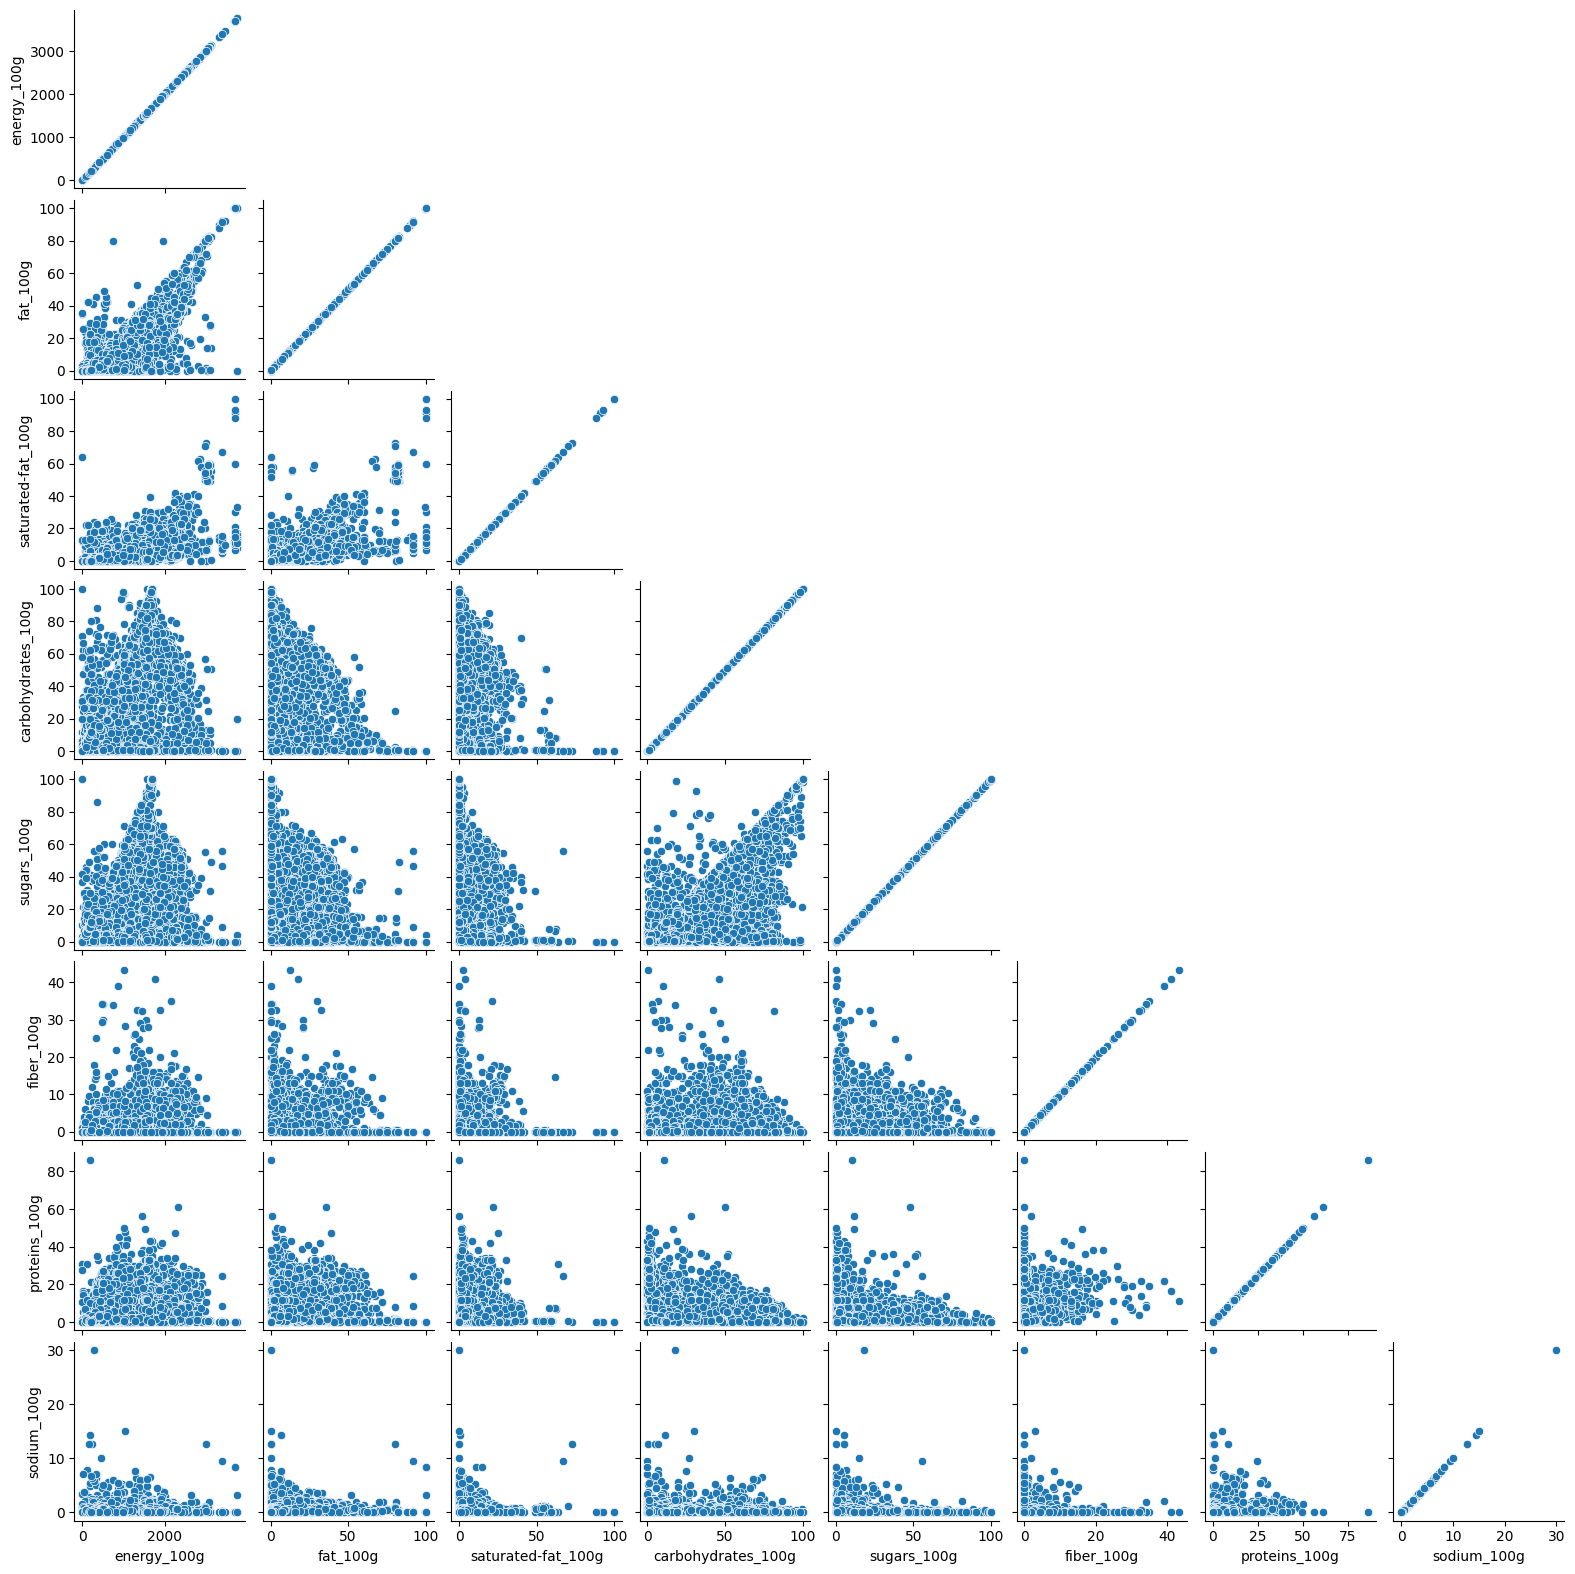

In [17]:
# display variables pairing
sns.pairplot(df.sample(10000), height=2, diag_kind= None, corner=True)
plt.show()

There is a significant correlation between the variables fat/energy (77%) and fat/saturated_fat (73%).

This observation is consistent with the fact that energy content is largely influenced by the presence of fat.

Also, given that saturated_fat is included in fats, it's not surprising to see this high correlation between the two.

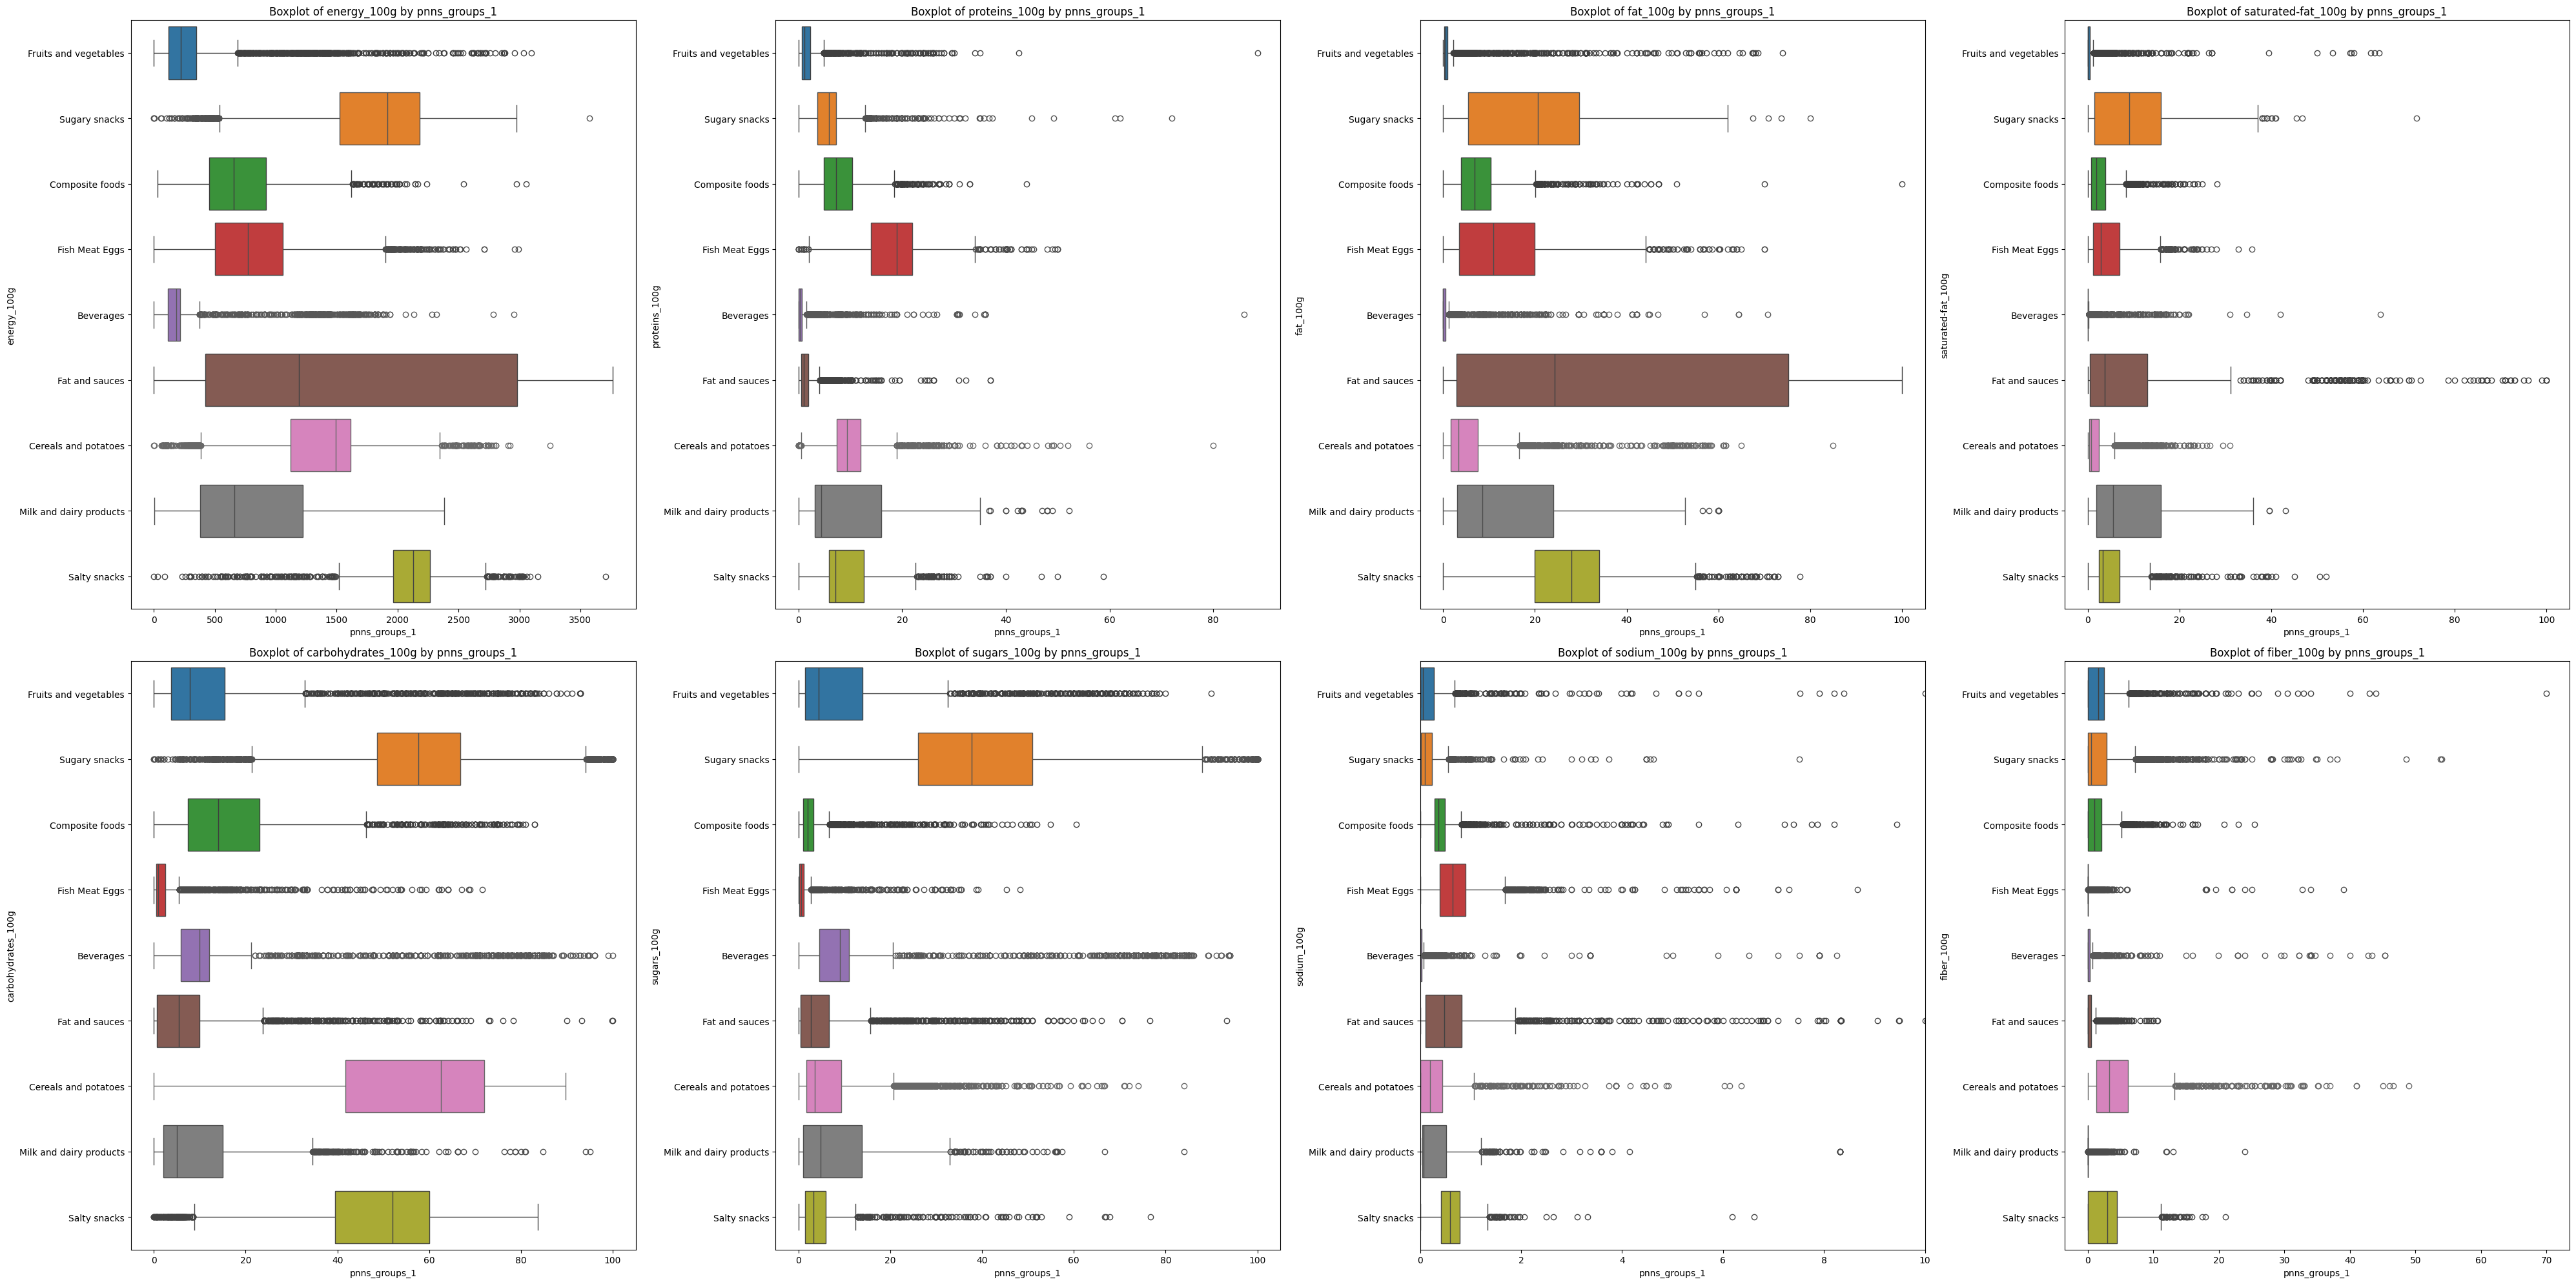

In [18]:
# plot target variable with quantitative variables
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))
axes = axes.flatten()
for i, var in enumerate(NUMERIC_FEATURES):
    for target_category in df[TARGET].unique():
        sns.boxplot(y=TARGET, x=var, data=df[df[TARGET] == target_category], ax=axes[i])
        axes[i].set_title(f'Boxplot of {var} by {TARGET}')
        axes[i].set_xlabel(TARGET)
        axes[i].set_ylabel(var)
        if i == 6:
          axes[i].set_xlim(0, 10)
plt.tight_layout()
plt.show()

Unsurprisingly, the foods richest in protein are found in the Fish Meat Egg group, while the foods richest in sugar are found in the Sugary Snack group.

In terms of carbohydrates, the Cereals and Potatoes group come out on top, as these foods contain slow sugars, along with the Sugary Snack group, which contains fast sugars. In contrast, the Fish Meat Egg modality is low in carbohydrates.

As for fat and saturated fat, the Fruits and Vegetables group contains very little, compared with the Sugary Snack and Fat and Sauces groups.

For the Salty snack group, we can see that the median for the fat category is in the top 3, but this isn't the case for the saturated-fat category.
This is explained by the fact that Salty snacks are often nuts/cashew nuts etc. which are high in fat but low in saturated-fat.

Fat and sugar contribute more to a high energy value. This explains why the Fat and sauces, Sugary Snack, Cereals and potatoes, and Salty snack groups are in the lead.

It is difficult to draw conclusions on the fiber and sodium modalities, as the values are very close.

## **B. Multivariate analysis**


In [20]:
# standartize with PowerTransformer and not StandardScaler because the distribution is not normal
scaler = PowerTransformer()
df1 = df[NUMERIC_FEATURES]
X = df1.values
X_scaled = scaler.fit_transform(X)

# check if standartized
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7
mean,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [21]:
n_components = 8
pca = PCA(n_components=n_components)
pca.fit(X_scaled)

PCA(n_components=8)

In [22]:
# linear combinations (Fi) of the original variables that capture the maximum variance in the data
x_list = list(range(1, n_components+1))
pcs = pca.components_
pcs = pd.DataFrame(pcs * 100).round()
pcs.columns = NUMERIC_FEATURES
pcs.index = [f"F{i}" for i in x_list]

(pcs.head(4).T)

,F1,F2,F3,F4
energy_100g,47.0,-29.0,-5.0,2.0
proteins_100g,40.0,19.0,33.0,-21.0
fat_100g,53.0,-0.0,-19.0,26.0
saturated-fat_100g,50.0,-2.0,-32.0,22.0
carbohydrates_100g,6.0,-60.0,18.0,-36.0
sugars_100g,-4.0,-57.0,-25.0,-31.0
sodium_100g,30.0,33.0,30.0,-62.0
fiber_100g,5.0,-29.0,75.0,48.0


In [23]:
# value of each principal component
Fi = pca.explained_variance_ratio_

for i in range (len(Fi)):
  print(f'F{i+1} = {round(Fi[i]*100, 2)} %')

F1 = 38.18 %
F2 = 26.89 %
F3 = 13.71 %
F4 = 7.85 %
F5 = 5.97 %
F6 = 4.44 %
F7 = 1.84 %
F8 = 1.12 %


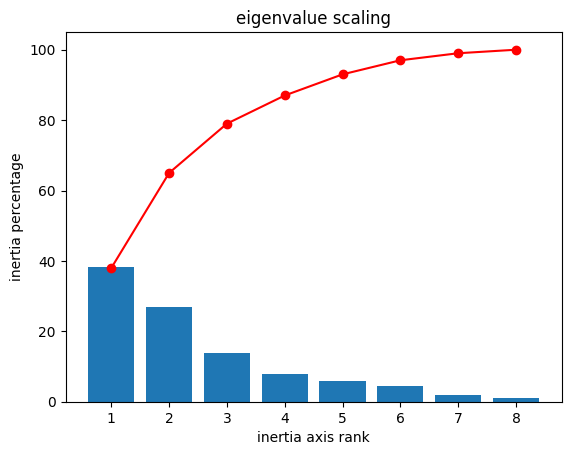

In [24]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("inertia axis rank")
plt.ylabel("inertia percentage")
plt.title("eigenvalue scaling")
plt.show(block=False)

The first plane (composed of PC1 and PC2) explains 65% of the variability in the data and the first two planes (composed of PC1, PC2, PC3, and PC4) explain 87% of the variability.

**FIRST AND SECOND PLANE**

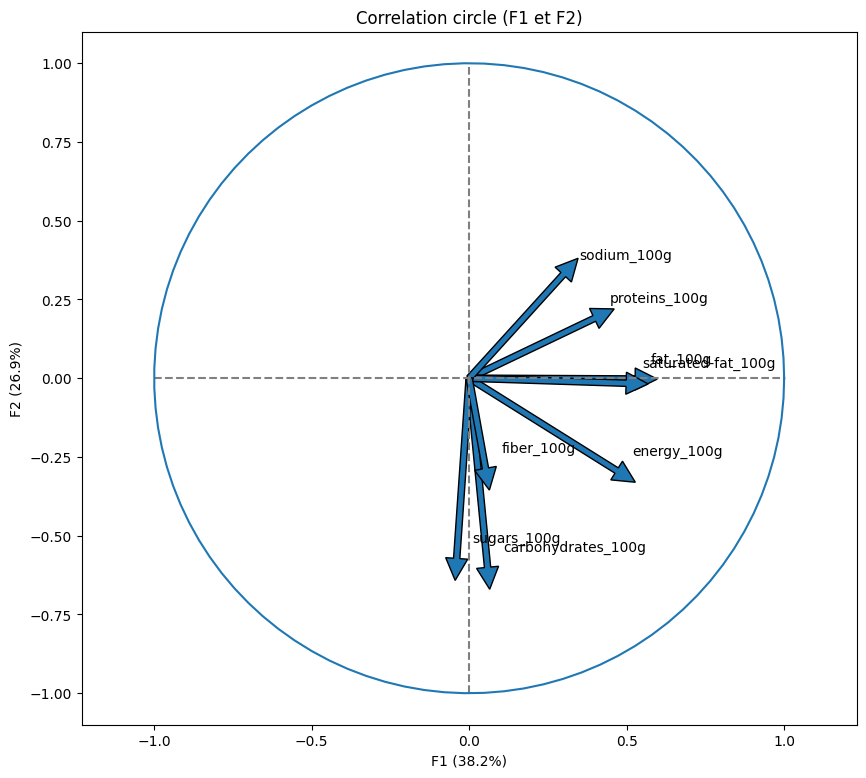

In [25]:
# first plane
correlation_graph(pca, (0,1), NUMERIC_FEATURES)

The length of the arrows shows that the variables are not very well projected in the first correlation circle and therefore their analysis is less precise.

The first principal component is highly correlated with the variables fat and saturated-fat.

The second principal component is highly correlated with sugar, carbohydrate and fiber.

We can suppose that F1 can represent fatness and F2 sweetness.

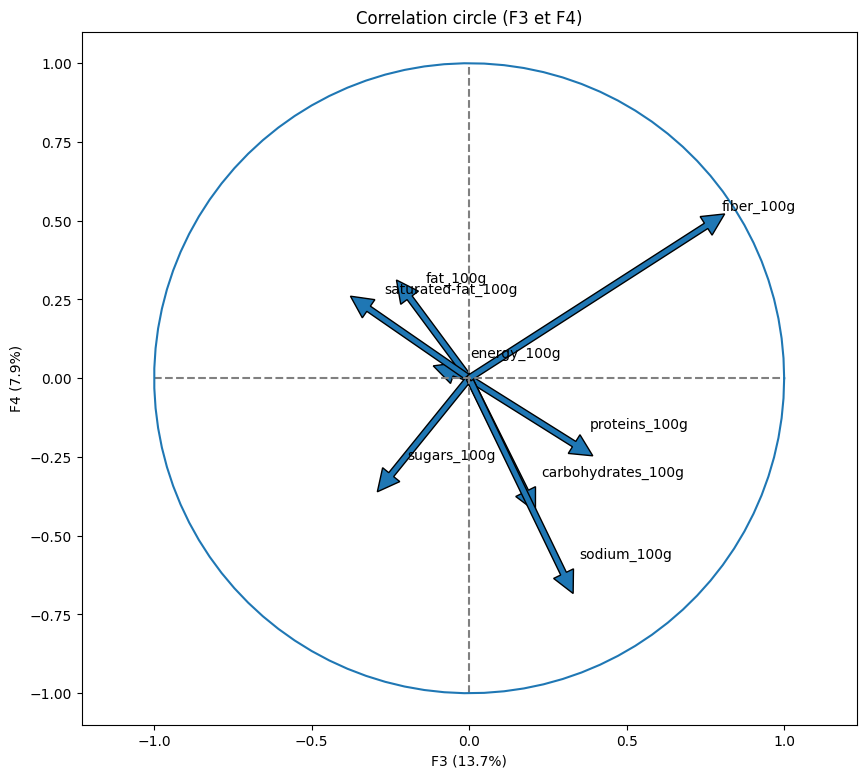

In [26]:
# second plane
correlation_graph(pca, (2,3), NUMERIC_FEATURES)

The length of the arrows shows that the variables fiber and sodium are well projected in the second correlation circle.

The third principal component is slightly correlated with the variables fiber and protein.

The fourth principal component is slightly correlated with sodium, carbohydrate and sugar.

We can suppose that F1 can represent fatness and F2 sweetness.

It's harder to determine the meaning of F3 a nd F4.

**INDIVIDUALS**

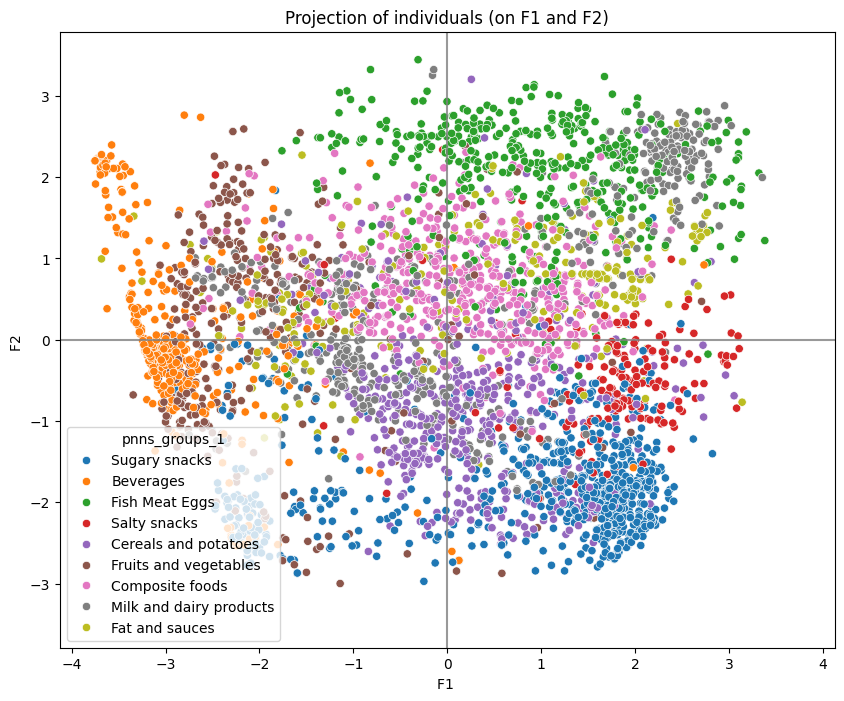

In [45]:
# extract a sample
df_sample = df.sample(4000)
df_sample_num = df_sample[NUMERIC_FEATURES]
X = df_sample_num.values
X_scaled = scaler.fit_transform(X)
X_proj = pca.transform(X_scaled)

# first plane
x_y = [0,1]
display_factorial_planes(X_proj, x_y, clusters=df_sample[TARGET])

F1 - we distinguish low-fat foods on the left, such as Beverages and Fruits and vegetables, and high-fat foods on the right, such as dairy products and salty snacks.

F2 - we distinguish foods which are sweet at the bottom, and the ones which are low in sugar at the top, such as high-protein products.

# **Conclusion**

**Data analysis**

Data analysis confirms data consistency.

The observations drawn are in line with business knowledge. Principal component analysis failed to highlight one or more principal components, due to improper representation of variables on the correlation circle.

**Feasibility of predicting the target variable**

The main objective is to determine if it is feasible to find a prediction method to fill in the missing data of the target variable pnns_groups_1.

The training dataset achieves a score of 96%, while the test dataset achieves a score of 88%, indicating overfitting.

However, this result is encouraging and represents a good score. Furthermore, it is possible to improve it through various means such as variable selection, imputation method, and model parameter tuning.

**Respecting RGPD**

The database meets the 5 principles of the RGPD.

- 1 Lawfulness, fairness and transparency

This principle does not pose a problem here, since the data processed are not of a personal nature.

- 2 Purpose limitation

This principle does not raise any problems here, as the purpose is archiving in the public interest.

- 3 Data minimization

This principle does not pose a problem here, since the data in the database is already available to the general public and is not personal.

- 4 Accuracy

The data is opensource, so if it's out of date, it can be quickly rectified.

- 5 Limitation of storage

For archiving purposes, the data can be stored for a long time if it's not personal which is the case here.